In [16]:
import pandas as pd
import numpy as np
from urllib import request
import nltk
import re
import spacy
import matplotlib.pyplot as plt
!pip install unidecode
import unidecode

from nltk import word_tokenize
from nltk.corpus import stopwords
#from nltk.probability import FreqDist
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from warnings import simplefilter
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Aquisição e estruturação do dataset

In [18]:
# Carregar os arquivos csv previamente baixados
drive.mount ('/drive') 
# Com tamanho normalizado 
df_fake = pd.read_csv("/drive/My Drive/Colab Notebooks/Fake News/fake.csv", dtype={'index': int, 'tipo': str, 'texto': str})
df_true = pd.read_csv("/drive/My Drive/Colab Notebooks/Fake News/true.csv", dtype={'index': int, 'tipo': str, 'texto': str})
drive.flush_and_unmount()

Mounted at /drive


In [19]:
df = pd.DataFrame(columns=['tipo','texto'])

#Mescla os dois datasets em um
df = df.append(df_fake, ignore_index=True)
df = df.append(df_true, ignore_index=True)

df

,tipo,texto
0,fake,Kátia Abreu diz que vai colocar sua expulsão e...
1,fake,Blog esquerdista dá a entender que reclamar de...
2,fake,"Alckmin diz que por ele PSDB “desembarca”, mas..."
3,fake,Cara de pau não tem limites: Zé Celso aciona M...
4,fake,Temer resolve o problema de Luislinda: “liberd...
...,...,...
7195,true,Ficou longe das notícias no fim de ano? Veja o...
7196,true,A nova denúncia contra o ex-presidente Luiz In...
7197,true,Como a Bahia virou uma potência mundial do mar...
7198,true,"Alvo da Lava Jato, Bendine tinha passagem comp..."


##Pré-processamento

Para ajudar na acurácia do classificador podemos filtrar informações desnecessárias e realizar outras manipulações para uma melhor classificação e extração de estatísticas das palavras que compõem o corpus.

Primeiramente o texto é convertido para letras minúsculas já que ajuda na comparação entre as palavras pois há diferença caso a mesma palavra seja escrita com letras maiúsculas ou minúsculas, por exemplo, "Presidente", "presidente" e "pResidente" são categorizadas como três palavras distintas.

Em seguida é realizado o tratamento dos numeros com "R$", é criado o token MOEDA; 
Logo após são removidas as tags html, os endereços URL e os numeros substituindo-os respectivamente com os tokens URL e 0; por fim é feita a remoção das stopwords e outros "ruídos" que podem estar no meio dos textos, como pontuação ou até caracteres especiais.

In [22]:
stop_words = stopwords.words('portuguese')

def pre_processamento(texto):
    texto = texto.lower()
    #texto = re.sub(r'[Rr]\$','', texto) #remove R$   
    texto = re.sub(r'[Rr][0-9]+(.[0-9][0-9])?','MOEDA', texto) #token MOEDA      
    texto = re.sub('<[^<]+?>','', texto) #remove tags html  
    texto = re.sub(r'http\S+', 'URL', texto) #remove url e substitui pelo token URL
    texto = re.sub('[0-9]+','0', texto) #remove números [0-9]+ e substitui pelo token 0
    #remove stopwords
    text_tokens = word_tokenize(texto, language='portuguese')
    sem_stopwords = [palavra for palavra in text_tokens if palavra not in stop_words]
    texto = (' ').join(sem_stopwords)   
    text_tokens = [palavra for palavra in sem_stopwords if palavra.isalpha()] #remove "ruidos"
    texto = (' ').join(text_tokens)
    texto =  unidecode.unidecode(texto) #remove acentuação
    
    return texto
      
df['txt_preprocess'] = df.apply(lambda row: pre_processamento(row['texto']), axis=1)


In [23]:
row = 786
display(df['texto'][row])

'Vice-ministro da Rússia diz que os EUA estão por trás de um "suposto" golpe no Brasil.  "Estamos abertos à cooperação com todos os governos de países interessados, desde que sejam governos legítimos",disse Sergei Ryabkov [vice-ministro].  (via Agência Sputinik) A Rússia fez uma declaração contundente sobre a crise brasileira e disse que observou "rastros" dos Estados Unidos na crise política que levou Michel Temer à presidência da República. "Um dos problemas mais importantes das relações internacionais contemporâneas é a tendência do Ocidente de manter a tudo o custo o domínio nos assuntos globais e regionais. A América Latina e o Caribe não são exceção. ", disse o vice-ministro Sergei Ryabkov.\r\n'

In [24]:
# Mesmo texto após o o pré-processamento
display(df['txt_preprocess'][row])

'russia diz eua tras suposto golpe brasil abertos cooperacao todos governos paises interessados desde governos legitimos disse sergei ryabkov via agencia sputinik russia fez declaracao contundente sobre crise brasileira disse observou rastros estados unidos crise politica levou michel temer presidencia republica problemas importantes relacoes internacionais contemporaneas tendencia ocidente manter tudo custo dominio assuntos globais regionais america latina caribe excecao disse sergei ryabkov'

In [25]:
df

,tipo,texto,txt_preprocess
0,fake,Kátia Abreu diz que vai colocar sua expulsão e...,katia abreu diz vai colocar expulsao moldura r...
1,fake,Blog esquerdista dá a entender que reclamar de...,blog esquerdista da entender reclamar dedada f...
2,fake,"Alckmin diz que por ele PSDB “desembarca”, mas...",alckmin diz psdb desembarca explica utilizara ...
3,fake,Cara de pau não tem limites: Zé Celso aciona M...,cara pau limites ze celso aciona mp contra sil...
4,fake,Temer resolve o problema de Luislinda: “liberd...,temer resolve problema luislinda liberdade ain...
...,...,...,...
7195,true,Ficou longe das notícias no fim de ano? Veja o...,ficou longe noticias fim ano veja aconteceu br...
7196,true,A nova denúncia contra o ex-presidente Luiz In...,nova denuncia contra luiz inacio lula silva pr...
7197,true,Como a Bahia virou uma potência mundial do mar...,bahia virou potencia mundial marketing politic...
7198,true,"Alvo da Lava Jato, Bendine tinha passagem comp...",alvo lava jato bendine passagem comprada portu...


In [27]:
df.txt_preprocess = df.txt_preprocess.astype(str).str.strip()

#Contar o número de palavras em cada texto e criar a coluna num_palavras para armazená-lo
df['num_palavras'] = df['txt_preprocess'].str.count(' ') + 1

#Contar total palavras fake e verdadeiras
df.groupby('tipo')[['num_palavras']].sum()

,num_palavras
tipo,
fake,366666
true,369396


In [28]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# Transformar a coluna 'tipo' em valores numericos (0-fake; 1-true) 
df.iloc[:,0]= labelencoder.fit_transform(df.iloc[:,0].values)
df

,tipo,texto,txt_preprocess,num_palavras
0,0,Kátia Abreu diz que vai colocar sua expulsão e...,katia abreu diz vai colocar expulsao moldura r...,76
1,0,Blog esquerdista dá a entender que reclamar de...,blog esquerdista da entender reclamar dedada f...,162
2,0,"Alckmin diz que por ele PSDB “desembarca”, mas...",alckmin diz psdb desembarca explica utilizara ...,113
3,0,Cara de pau não tem limites: Zé Celso aciona M...,cara pau limites ze celso aciona mp contra sil...,80
4,0,Temer resolve o problema de Luislinda: “liberd...,temer resolve problema luislinda liberdade ain...,80
...,...,...,...,...
7195,1,Ficou longe das notícias no fim de ano? Veja o...,ficou longe noticias fim ano veja aconteceu br...,104
7196,1,A nova denúncia contra o ex-presidente Luiz In...,nova denuncia contra luiz inacio lula silva pr...,252
7197,1,Como a Bahia virou uma potência mundial do mar...,bahia virou potencia mundial marketing politic...,105
7198,1,"Alvo da Lava Jato, Bendine tinha passagem comp...",alvo lava jato bendine passagem comprada portu...,129


##Mineração

Uso da biblioteca Scikit-Learn para gerar estatísticas das palavras do corpus. O corpus é convertido em uma matriz com valores de TF-IDF usando uni e bigramas mais importantes para classificar cada notícia.


In [29]:
# Parametros da Vectorização - palavras e bigramas
NGRAM_RANGE = (1, 2)

# Limite do número de features usado para selecionar as TOP_K melhores features 
TOP_K = 20000

# Criar argumentos para passar para o 'tf-idf' vectorizer.
kwargs = { 'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams
           'decode_error': 'replace',
}
    
vectorizer = TfidfVectorizer(**kwargs)
selector = SelectKBest(f_classif, k=TOP_K)

##Modelagem


In [30]:
# Divide os dados em duas variáveis independentes
X = df['txt_preprocess'] 
Y = df['tipo']

In [31]:
# Criando modelo de Machine Learning a partir de vários algoritmos
# Cria pipelines para vetorizar, extrair as palavras mais importantes e treinar o modelo
pipelines = []
pipelines.append(('LOG', Pipeline([('vect', vectorizer), ('selector',  selector),('LOG', LogisticRegression())]))),
pipelines.append(('PAC', Pipeline([('vect', vectorizer), ('selector',  selector),('PAC', PassiveAggressiveClassifier())]))),
pipelines.append(('KNN', Pipeline([('vect', vectorizer), ('selector',  selector),('KNN', KNeighborsClassifier())]))),
pipelines.append(('TREE', Pipeline([('vect', vectorizer), ('selector',  selector),('TREE', DecisionTreeClassifier())]))),
pipelines.append(('MNB', Pipeline([('vect', vectorizer), ('selector',  selector),('MNB', MultinomialNB())]))),
pipelines.append(('RF', Pipeline([('vect', vectorizer), ('selector',  selector),('RF', RandomForestClassifier())])))

# Média dos F1-Score de cada um dos modelos por validação cruzada e o desvio padrão
for nome, modelo in pipelines:
    kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)
    cross_val_result = model_selection.cross_val_score(modelo, X, Y, cv = kfold, scoring='f1')
    print(f'{nome}: {round(cross_val_result.mean(), 3)} (+/- {round(cross_val_result.std()*2, 3)})')

LOG: 0.888 (+/- 0.014)
PAC: 0.905 (+/- 0.017)
KNN: 0.584 (+/- 0.212)
TREE: 0.752 (+/- 0.031)
MNB: 0.868 (+/- 0.027)
RF: 0.884 (+/- 0.022)


In [32]:
# Os algoritmos de Regressão Logística e Passivo-Agressivo obtiveram uma melhor pontuação
# Vamos agora fazer um ajuste dos hiperparâmetros para tentar otimizá-los
# Ajuste dos hiperparâmetros do algoritmo Regressão Logística
from scipy.stats import uniform
 
X_vect = selector.fit_transform(vectorizer.fit_transform(X), Y)

log = LogisticRegression(tol=1e-2)
distributions = dict(C=uniform(loc=0, scale=4), 
                     max_iter = (100, 150, 200, 250, 300),
                     solver = ['lbfgs','liblinear', 'sag', 'saga'])
kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)
clf = model_selection.RandomizedSearchCV(log, distributions, cv = kfold)

search = clf.fit(X_vect, Y)
print(search.best_params_)

print("Melhor score: %0.3f" % search.best_score_)
print("Melhores parâmetros:")
best_parameters = search.best_estimator_.get_params()
for param_name in sorted(distributions.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

{'C': 3.5586273124730057, 'max_iter': 200, 'solver': 'lbfgs'}
Melhor score: 0.924
Melhores parâmetros:
	C: 3.5586273124730057
	max_iter: 200
	solver: 'lbfgs'


In [33]:
# Ajuste de hiperparâmetros do PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(tol=1e-2)
distributions = dict(C=uniform(loc=0, scale=4),
                     loss = ['hinge', 'squared_hinge'],
                     fit_intercept = [True, False])
kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)
clf = model_selection.RandomizedSearchCV(pac, distributions, cv = kfold)

search = clf.fit(X_vect, Y)
print(search.best_params_)

print("Best score: %0.3f" % search.best_score_)
print("Best parameters set:")
best_parameters = search.best_estimator_.get_params()
for param_name in sorted(distributions.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

{'C': 0.3204778339132557, 'fit_intercept': True, 'loss': 'squared_hinge'}
Best score: 0.940
Best parameters set:
	C: 0.3204778339132557
	fit_intercept: True
	loss: 'squared_hinge'


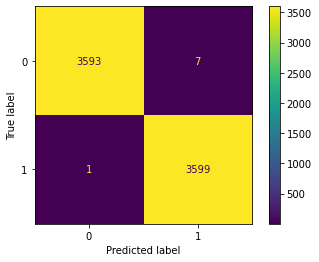

In [38]:
# Plotar a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(search, X_vect, Y)
plt.show()

##O algoritmo PassiveAgressiveClassifier foi o que teve a melhor performance

In [34]:
# Preparando a versão final do modelo.
X = df['txt_preprocess']
Y = df['tipo'] 
X_vect = selector.fit_transform(vectorizer.fit_transform(X), Y)

modelo_pac = PassiveAggressiveClassifier(C=best_parameters['C'], tol=1e-2,
                                         loss=best_parameters['loss'],
                                         fit_intercept=best_parameters['fit_intercept'], 
                                         random_state=7).fit(X_vect, Y)

result_pac = cross_val_predict(modelo_pac, X_vect, Y, cv=10)

print(f'Acurácia: {accuracy_score(Y, result_pac)}')
print('\n',confusion_matrix(Y, result_pac))
print('\n',classification_report(Y, result_pac))


In [36]:
# Salvar o modelo treinado e o vetorizador no formato pickle 
pipeline = Pipeline([('vect', vectorizer), 
                     ('selector',  selector),
                     ('PAC', modelo_pac)])

with open('PassiveAgressive.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Fazer download do arquivo pickle
from google.colab import files
files.download('PassiveAgressive.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Testar se da para usar o modelo sem treinar novamente
# Carregar o modelo
row = 7195
texto = df['txt_preprocess'][row]
pac_model = pickle.load(open('PassiveAgressive.pkl', 'rb'))

print("Previsão: ", str(pac_model.predict([texto])), "Real: ", str(df['tipo'][row]) )

Previsão:  [1] Real:  1
